## ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Project 3: NLP Classification: Subreddit Pepsi vs Coca-Cola | Part 1: EDA

---

[README](../README.md) | **Part 1: EDA** | [Part 2: Vectorizer](02_Vectorizer.ipynb) | [Part 3: Vectorizer Performance](03_Vectorizer_Performance.ipynb) | [Part 4: Model Tuning](04_Model_Tuning.ipynb)

---

### Introduction
We will explore the distinguishing patterns between two subreddits: **Pepsi** and **Coca-Cola** and. The data from both subreddits has been extracted into the file `subreddit_pepsi_vs_cocacola.csv` using Reddit APIs.

### Import

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

# install wordcolud 
# !pip install wordcloud

from wordcloud import WordCloud

In [53]:
# Set random seed for reproducing work
np.random.seed(42)

### Data Preparation
- The original extracted data contains seven columns: `title`, `score`, `id`, `url`, `comms_num`, `created`, and `body`. An additional column, `is_pepsi`, was created to distinguish between the two subreddits: **Pepsi** and **Coca-Cola**.
- Since some posts have no text in the `body` field, we will create a new column, `title_body`, which concatenates the `title` and `body` columns.
- We will also create `title_body_length` and `title_body_word_count`, representing the total number of characters and total number of words in `title_body`, respectively.

In [55]:
df = pd.read_csv('../data/subreddit_pepsi_vs_cocacola.csv')          # Load Data
df.head()                                                            # Check first 5 rows

,title,score,id,url,comms_num,created,body,is_pepsi
0,Wall clock.,17,1godhom,https://www.reddit.com/gallery/1godhom,1,11/11/2024 5:58,I'm trying to locate a value for this clock. I...,0
1,"Happy Veterans Day!, Coca Cola poster sealed d...",4,1gojyxe,https://i.redd.it/a3xsqwwaa70e1.jpeg,0,11/11/2024 11:31,NaN,0
2,What do yall like better,30,1go7cpq,https://www.reddit.com/gallery/1go7cpq,85,11/11/2024 1:33,Diet coke or coke and why,0
3,Every drink company cola has owned and owns an...,0,1goc0ni,https://miro.com/app/board/uXjVM_YVujs=/,1,11/11/2024 4:53,NaN,0
4,Wall thermometer,22,1gnaebp,https://i.redd.it/13cyo811rvzd1.jpeg,4,11/9/2024 20:44,Vintage wall thermometer my Dad had.,0


In [56]:
df.shape

(1958, 8)

In [57]:
# The only column that contains NaN values is `body`, with 713 rows, which is 36.41% of the 1,958 rows. 
# We will create a new column called title_body."

pd.concat([df.isnull().sum(), df.isnull().mean().mul(100).round(2)]
          , axis=1, keys=['Null Count', 'Null %']).sort_values(by = ['Null %'], ascending = False)

,Null Count,Null %
body,713,36.41
title,0,0.00
score,0,0.00
id,0,0.00
url,0,0.00
comms_num,0,0.00
created,0,0.00
is_pepsi,0,0.00


In [58]:
df['title_body'] = df['title'] + ' ' + df['body'].fillna('')

In [59]:
df['is_pepsi'].value_counts(normalize = True)

is_pepsi
1    0.508172
0    0.491828
Name: proportion, dtype: float64

In [60]:
df['title_body_length'] = df['title_body'].apply(lambda x: len(x))                 # Whitespaces are included

In [61]:
df['title_body_word_count'] = df['title_body'].apply(lambda x: len(x.split()))     # Count words using whitespace as delimiter

In [62]:
df.to_csv('../data/subreddit_pepsi_vs_cocacola_clean.csv', index = False)

### Exploratory and Explanatory Data Analysis

#### Title Body Length & Title Body Word Count

- **Similarities in Lower Quartiles**: Both **Pepsi** and **Coca-Cola** show similar patterns in the first quartile and median, with only slight differences.
- **Differences in Higher Quartiles**: The third quartile and maximum values show clear differences, with **Pepsi** generally having longer titles (both in terms of length and word count) at the higher end of the distributions.

In [65]:
df[['is_pepsi', 'title_body_length', 'title_body_word_count']].groupby('is_pepsi').describe().T

is_pepsi                               0            1
title_body_length     count   963.000000   995.000000
                      mean    188.470405   217.090452
                      std     228.526123   317.767885
                      min       2.000000     6.000000
                      25%      53.500000    49.000000
                      50%     116.000000   120.000000
                      75%     233.000000   282.500000
                      max    2489.000000  4182.000000
title_body_word_count count   963.000000   995.000000
                      mean     33.983385    39.886432
                      std      39.432668    60.296168
                      min       1.000000     1.000000
                      25%       9.000000     9.000000
                      50%      21.000000    22.000000
                      75%      43.000000    51.000000
                      max     468.000000   809.000000

In [66]:
# The .idxmax() method retrieves the index of the row with the maximum value of 'title_body_word_count
df.loc[df.groupby('is_pepsi')['title_body_word_count'].idxmax(), ['is_pepsi', 'title_body', 'title_body_length', 'title_body_word_count']]

,is_pepsi,title_body,title_body_length,title_body_word_count
653,0,"Bad Dr Pepper cans advice Hi everyone, I recen...",2489,468
1166,1,Pepsi Chronicles 1 I am currently a sales rep...,4182,809


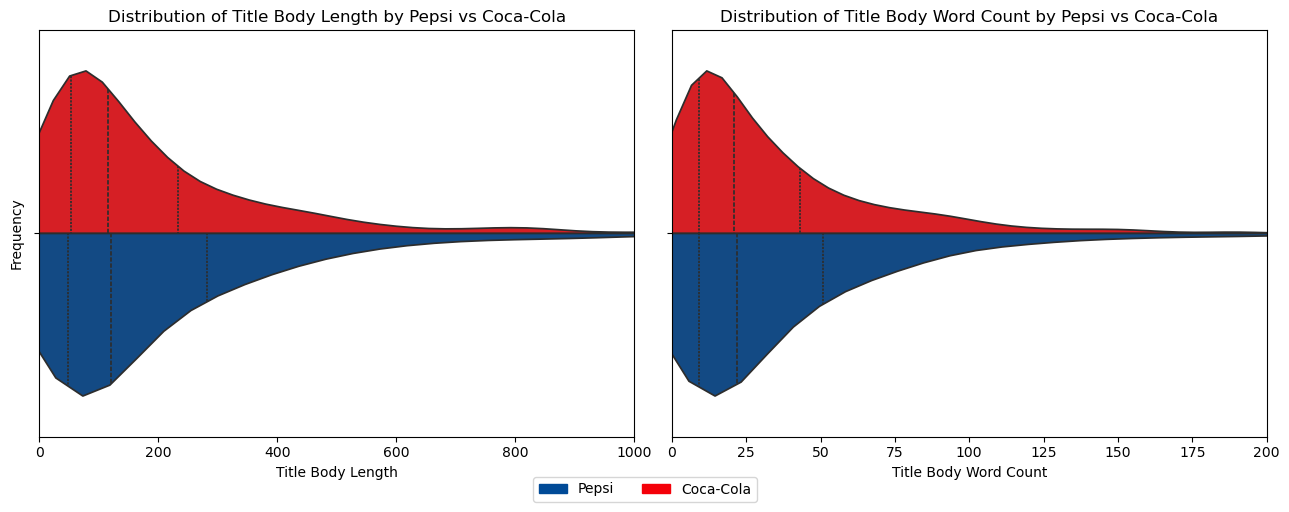

In [67]:
# The distribution of 'title body length' and 'title body word count'
# The plots are shown by violin plots

pc_colors = {1: "#004A97", 0: "#F40009"}    # 1 = blue color of pepsi, 0 = red color of coca-cola

fig, ax = plt.subplots(1, 2, figsize=(13, 5))

# Title Body Length
sns.violinplot(data = df
               , hue = 'is_pepsi'
               , x = 'title_body_length'
               , split = True
               , inner = 'quart'
               , fill = True
               , palette = pc_colors
               , ax = ax[0]
               , legend = False
              )
ax[0].set_title('Distribution of Title Body Length by Pepsi vs Coca-Cola')
ax[0].set_xlabel('Title Body Length')
ax[0].set_ylabel('Frequency')
ax[0].set_xlim(0, 1000)

# Title Body Word Count
sns.violinplot(data = df
               , hue = 'is_pepsi'
               , x = 'title_body_word_count'
               , split = True
               , inner = 'quart'
               , fill = True
               , palette = pc_colors
               , ax = ax[1]
               , legend = False
              )
ax[1].set_title('Distribution of Title Body Word Count by Pepsi vs Coca-Cola')
ax[1].set_xlabel('Title Body Word Count')
#ax[1].set_ylabel('Frequency')
ax[1].set_xlim(0, 200)

# Custom Legend
pepsi_patch = mpatches.Patch(color = pc_colors[1], label='Pepsi')
coca_cola_patch = mpatches.Patch(color = pc_colors[0], label='Coca-Cola')

# Add the custom legend to the figure
fig.legend(handles = [pepsi_patch, coca_cola_patch]
           , loc='upper center'
           , ncol = 2
           , bbox_to_anchor=(0.5, 0.05)
          )

plt.tight_layout()
# plt.savefig('../images/pepsi_vs_coca_cola_violin_plot.png', dpi = 300, bbox_inches = 'tight')
plt.show();

#### Common and Exclusive words
- After vectorization with CountVectorizer and removing brand-specific words, there are 6,309 features.
- These are the top 20 common words: like, just, know, new, im, zero, does, sugar, bottle, got, time, taste, cans, job, oreo, store, drink, good, merchandiser, and did. Interestingly, *oreo* is a word that mostly appears only in **Coca-Cola**, so it will be considered an exclusive word.
- Other exclusive words are: job, position, sales, and interview for **Pepsi**; and oreo, zero, bottle, and taste for **Coca-Cola**.

In [69]:
pc_stopwords = list(ENGLISH_STOP_WORDS.union({'pepsi'
                                              , 'pepsico'
                                              , 'coca'
                                              , 'cola'
                                              , 'coke'}))  # Add specific related words of Pepsi and Coca-Cola
cvec = CountVectorizer(stop_words = pc_stopwords, strip_accents = 'ascii')        # instatiate vectorizer using custom stopwords and remove accents
X = cvec.fit_transform(df['title_body']).todense()                                # Fitting, Transforming and Densing
df_X = pd.DataFrame(X, columns = cvec.get_feature_names_out())                    # Results

In [70]:
df_X.shape

(1958, 6309)

In [71]:
# Number of ocurrences of each word group by `is_pepsi`
df_X_pc = pd.concat([df['is_pepsi'], df_X], axis = 1).groupby('is_pepsi').sum()
df_X_pc.T.tail(1)

is_pepsi,0,1
zusauzfeftq,1,0


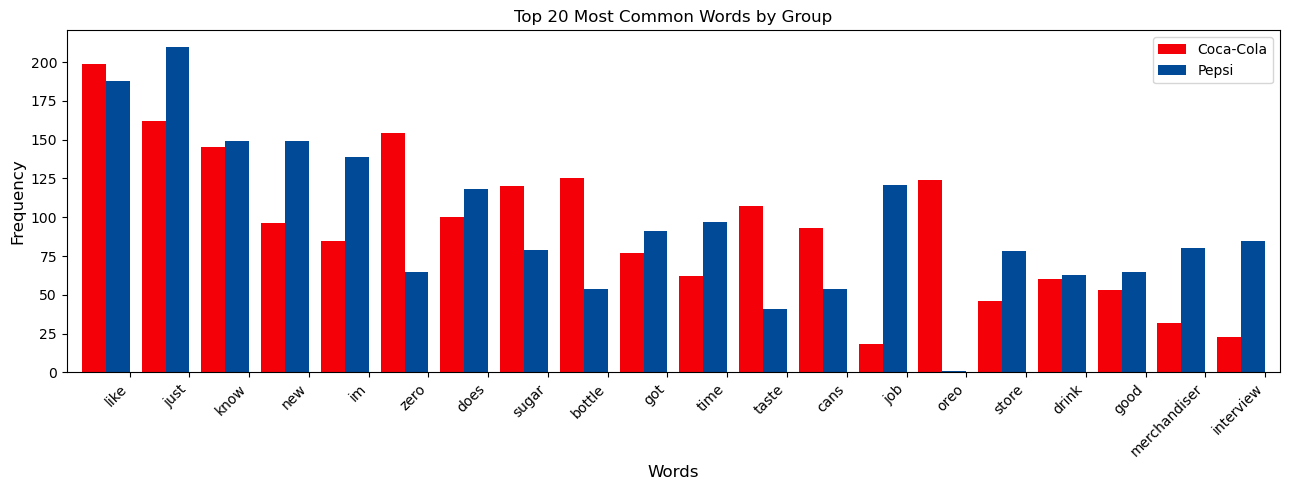

In [72]:
# Top N common words

# Set N
N = 20

word_frequencies = df_X_pc.loc[0] + df_X_pc.loc[1]                             # Calculate total word frequencies
top_words = word_frequencies.sort_values(ascending = False).head(20).index     # Sort and select top N words as List
df_top_words = df_X_pc[top_words]                                              # Filter                                               

# Plot the grouped bar chart
ax = df_top_words.T.plot(
    kind = 'bar'
    , width = 0.8
    , figsize = (13, 5)
    , color = [pc_colors[0], pc_colors[1]]
    , position=1
)

# Add labels and title
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Top {N} Most Common Words by Group')

# Add legend
plt.legend(labels=['Coca-Cola', 'Pepsi'], loc = 'upper right')

# Adjust x-axis
plt.xticks(rotation = 45, ha = 'right')

# Show plot
plt.tight_layout()
# plt.savefig('../images/pepsi_vs_coca_cola_common_word.png', dpi = 300, bbox_inches = 'tight')
plt.show();

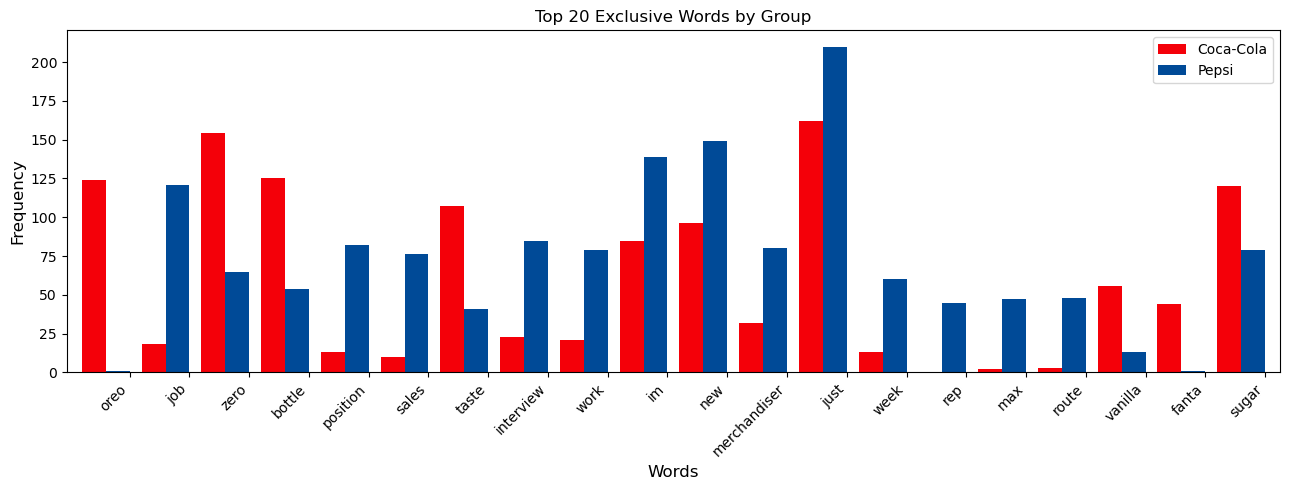

In [73]:
# Top N exclusive words

# Set N
N = 20

word_frequencies_x = abs(df_X_pc.loc[0] - df_X_pc.loc[1])                              # Difference between frequencies
exclusive_words = word_frequencies_x.sort_values(ascending = False).head(20).index     # Sort and select top N exclusive words as List
df_exclusive_words = df_X_pc[exclusive_words]                                          # Filter                                               

# Plot the grouped bar chart
ax = df_exclusive_words.T.plot(
    kind = 'bar'
    , width = 0.8
    , figsize = (13, 5)
    , color = [pc_colors[0], pc_colors[1]]
    , position = 1
)

# Add labels and title
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Top {N} Exclusive Words by Group')

# Add legend
plt.legend(labels=['Coca-Cola', 'Pepsi'], loc = 'upper right')

# Adjust x-axis
plt.xticks(rotation = 45, ha = 'right')

# Show plot
plt.tight_layout()
# plt.savefig('../images/pepsi_vs_coca_cola_exclusive_word.png', dpi = 300, bbox_inches = 'tight')
plt.show();

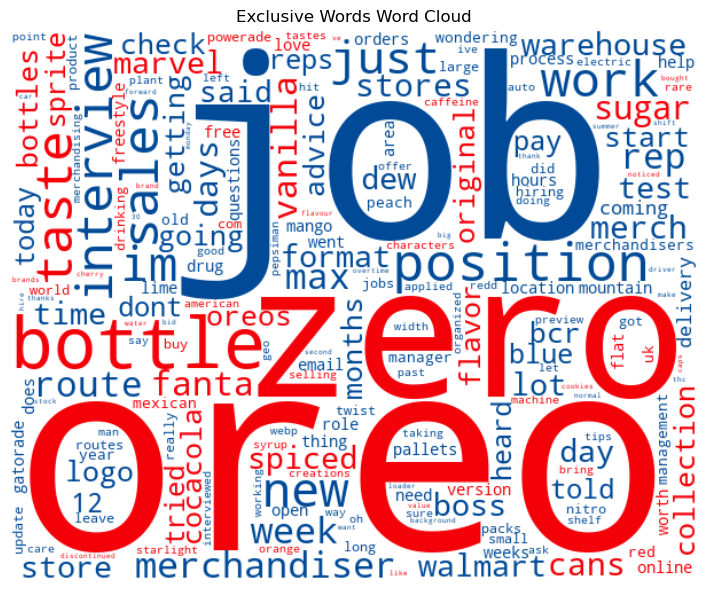

In [74]:
word_diff = df_X_pc.iloc[1] - df_X_pc.iloc[0]           # The difference frequency between pepsi and coca-cola
word_diff_abs = word_diff.abs()                         # Get Absolute for word cloud
word_diff_dict = word_diff_abs.to_dict()                # Dictionary for word cloud

def color_func(word, **kwargs):
    diff = word_diff_dict.get(word, 0)
    original_diff = word_diff.get(word, 0)
    
    if original_diff > 0:
        return pc_colors[1]                             # Blue if the word frequency in Pepsi is higher than in Coca-Cola
    elif original_diff < 0:
        return pc_colors[0]                             # Red if the word frequency in Coca-Cola is higher than in Pepsi
    else:
        return 'gray'                                   # Otherwise

# Create the word cloud from the frequency differences
wordcloud = WordCloud(width = 600
                      , height = 480
                      , background_color='white'
                      , color_func = color_func).generate_from_frequencies(word_diff_dict)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Exclusive Words Word Cloud')

plt.tight_layout()
# plt.savefig('../images/pepsi_vs_coca_cola_exclusive_word_cloud.png', dpi = 300, bbox_inches = 'tight')
plt.show();